This notebook uses property features to predict their prices using Linear, Lasso & Random Forest regression. <br> 
Data was taken from from New York City Real Estate Sales, 2015, https://geo.nyu.edu/catalog/nyu-2451-34678, with detailed explanation of varibles at https://www1.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf.

In [1]:
import os 
import pandas as pd
import numpy as np 

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning
import sklearn

#one-hot encoding 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer 

# Data Scaler
from sklearn.preprocessing import StandardScaler

# Stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Train test split and regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

%matplotlib inline 

In [2]:
os.chdir("C:/Users/mmlad/Desktop/Drive/MS Data Science/Fundamentals of data science/Assignment 4")
df = pd.read_csv("sales_data_2015.csv", low_memory=False) #simply silences an error that columns have mixed types 
#pandas guessing column data type cannot happen until it has read entire file, which can be memory consuming?

pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,Sale_id,bbl_id,year,borough,bldg_ctgy,tax_cls_p,block,lot,easmnt,bldg_cls_p,address,apt,zip,res_unit,com_unit,tot_unit,land_sqft,tot_sqft,yr_built,tax_cls_s,bldg_cls_s,sale_date,price,usable,long,lat
0,0,1,2290528,2015,2,01 ONE FAMILY DWELLINGS,1,2905,28,NaN,A9,1665 WASHINGTON AVENUE,NaN,10457,1,0,1,4750,2619,1899,1,A9,08-07-15,0,N,-73.901338,40.841229
1,1,2,2290528,2015,2,01 ONE FAMILY DWELLINGS,1,2905,28,NaN,A9,1665 WASHINGTON AVENUE,NaN,10457,1,0,1,4750,2619,1899,1,A9,08-07-15,0,N,-73.901338,40.841229
2,2,3,230352,2015,2,01 ONE FAMILY DWELLINGS,1,3035,2,NaN,S1,441 EAST 178 STREET,NaN,10457,1,1,2,1287,2528,1899,1,S1,12/18/2015,0,N,-73.898331,40.848648
3,3,4,2303936,2015,2,01 ONE FAMILY DWELLINGS,1,3039,36,NaN,S1,455 EAST 184 STREET,NaN,10458,1,1,2,2500,2452,1910,1,S1,08/18/2015,0,N,-73.893338,40.856136
4,4,5,2303936,2015,2,01 ONE FAMILY DWELLINGS,1,3039,36,NaN,S1,455 EAST 184 STREET,NaN,10458,1,1,2,2500,2452,1910,1,S1,07-01-15,400000,Y,-73.893338,40.856136


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84768 entries, 0 to 84767
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  84768 non-null  int64  
 1   Sale_id     84768 non-null  int64  
 2   bbl_id      84768 non-null  int64  
 3   year        84768 non-null  int64  
 4   borough     84768 non-null  int64  
 5   bldg_ctgy   84768 non-null  object 
 6   tax_cls_p   84765 non-null  object 
 7   block       84768 non-null  int64  
 8   lot         84768 non-null  int64  
 9   easmnt      1 non-null      object 
 10  bldg_cls_p  84765 non-null  object 
 11  address     84768 non-null  object 
 12  apt         20983 non-null  object 
 13  zip         84768 non-null  int64  
 14  res_unit    84768 non-null  int64  
 15  com_unit    84768 non-null  int64  
 16  tot_unit    84768 non-null  int64  
 17  land_sqft   84768 non-null  int64  
 18  tot_sqft    84768 non-null  int64  
 19  yr_built    84768 non-nul

In [4]:
print(df.Sale_id.nunique()) #checking for duplicates --> there are none
print("tax classes:",df.tax_cls_s.nunique(),"building classes:",df.bldg_cls_s.nunique()) #4 tax classes

84768
tax classes: 4 building classes: 173


# Data processing


## 1) Getting a usable dataframe

1. Removing non-usable buildings (e.g. buildings sold for <= 10 dollars as a way of passing on tax-free inheritance)
2. Removing noninformative explanatory variables (incl. ones with too many NaN values)

In [5]:
df = df[df['usable'].str.contains("Y")] #(price <=10)
df = df.drop(columns=["usable", "easmnt", "apt"]) #columns with NaN for most rows 
df = df.drop(columns=["year","tax_cls_p", "bldg_cls_p","block","lot", "address", "long", "lat", "sale_date"]) # columns not adding valuable data for analysis 
df = df.drop(columns=["Unnamed: 0", "bbl_id"]) #these could serve as indices, but I will use the sale_id as index 
df = df.set_index('Sale_id')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59822 entries, 5 to 84766
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   borough     59822 non-null  int64 
 1   bldg_ctgy   59822 non-null  object
 2   zip         59822 non-null  int64 
 3   res_unit    59822 non-null  int64 
 4   com_unit    59822 non-null  int64 
 5   tot_unit    59822 non-null  int64 
 6   land_sqft   59822 non-null  int64 
 7   tot_sqft    59822 non-null  int64 
 8   yr_built    59822 non-null  int64 
 9   tax_cls_s   59822 non-null  int64 
 10  bldg_cls_s  59822 non-null  object
 11  price       59822 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 5.9+ MB


## Preparing for one-hot encoding

#### Preparing for one-hot encoding

In [7]:
df['borough'][df['borough'] == 1] = 'Manhattan'
df['borough'][df['borough'] == 2] = 'Bronx'
df['borough'][df['borough'] == 3] = 'Brooklyn'
df['borough'][df['borough'] == 4] = 'Queens'
df['borough'][df['borough'] == 5] = 'Staten Island'

C:\Users\mmlad\.conda\envs\Data Sci Python 36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
df['tax_cls_s'][df['tax_cls_s'] == 1] = 'a'
df['tax_cls_s'][df['tax_cls_s'] == 2] = 'b'
df['tax_cls_s'][df['tax_cls_s'] == 3] = 'c'
df['tax_cls_s'][df['tax_cls_s'] == 4] = 'd'

C:\Users\mmlad\.conda\envs\Data Sci Python 36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\mmlad\.conda\envs\Data Sci Python 36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mmlad\.conda\envs\Data Sci Python 36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

#### Exploring how many columns will get added during the one-hot encoding: 

In [9]:
#Select the variables to be one-hot encoded
one_hot_features = ['borough', 'tax_cls_s']

# For each categorical column, find the unique number of categories. This tells us how many columns we are adding to the dataset.
longest_str = max(one_hot_features, key=len)
total_num_unique_categorical = 0

for feature in one_hot_features:
    num_unique = len(df[feature].unique())
    print('{col:<{fill_col}} : {num:d} unique categorical values.'.format(col=feature, 
                                                                          fill_col=len(longest_str),
                                                                          num=num_unique))
    total_num_unique_categorical += num_unique
print('{total:d} columns will be added during one-hot encoding.'.format(total=total_num_unique_categorical))

borough   : 5 unique categorical values.
tax_cls_s : 4 unique categorical values.
9 columns will be added during one-hot encoding.


## 2) Data cleaning: removing for NaN and incorrectly entered values in all columns

In [10]:
#Investigating incorrect entries: 
print("Entries with incorrect year: ", len(df[df.yr_built == 0]))
print("Entries with incorrect price: ",len(df[df.price == 0])) #1 entry was mistakenly labelled as usable despite price set as 0
print("Entries with incorrect ZIP code: ",len(df[df.zip == 0])) #25
print("Entries with incorrect borough: ",len(df[df.borough == 0])) #0
print("Entries with incorrectly entered size: ",len(df[(df.tot_sqft == 0) & (df.land_sqft == 0)]))
print("Original dataset length: ",len(df))

#Removing incorrect entries:
#sales_df2 = sales_df[(sales_df.tot_sqft != 0) | (sales_df.land_sqft != 0)] #alternative cleaning
df2 = df[df.tot_sqft != 0]
df2 = df2[(df.yr_built != 0) & (df.price != 0) & (df.zip != 0)]

df2 = df2[df2.tot_unit == df2.com_unit + df2.res_unit]
df2 = df2[df2.tot_unit > 0]

print("Cleaned dataset length: ", len(df2))

Entries with incorrect year:  3697
Entries with incorrect price:  1
Entries with incorrect ZIP code:  25
Entries with incorrect borough:  0
Entries with incorrectly entered size:  30775
Original dataset length:  59822
Cleaned dataset length:  27980


C:\Users\mmlad\.conda\envs\Data Sci Python 36\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


In [11]:
#Transforming year built into building age
df2["bldg_age"]= 2016- df2["yr_built"]
df2 = df2.drop(columns = ["yr_built"])
df2

,borough,bldg_ctgy,zip,res_unit,com_unit,tot_unit,land_sqft,tot_sqft,tax_cls_s,bldg_cls_s,price,bldg_age
Sale_id,,,,,,,,,,,,
5,Bronx,01 ONE FAMILY DWELLINGS,10458,1,1,2,2500,2452,a,S1,400000,106
8,Bronx,02 TWO FAMILY DWELLINGS,10457,2,0,2,2000,2400,a,B1,430000,23
9,Bronx,02 TWO FAMILY DWELLINGS,10457,2,0,2,2000,2400,a,B1,10000,23
10,Bronx,02 TWO FAMILY DWELLINGS,10457,2,0,2,3165,2394,a,B1,505000,21
11,Bronx,02 TWO FAMILY DWELLINGS,10457,2,1,3,1620,3240,a,S2,490000,85
...,...,...,...,...,...,...,...,...,...,...,...,...
84759,Staten Island,02 TWO FAMILY DWELLINGS,10309,2,0,2,3447,1200,a,B9,465000,18
84760,Staten Island,02 TWO FAMILY DWELLINGS,10309,2,0,2,5645,1550,a,B9,515000,19
84762,Staten Island,02 TWO FAMILY DWELLINGS,10309,2,0,2,5700,1600,a,B2,165000,19


## 3) One-hot encoding 

In [12]:
one_hot_encoded = pd.get_dummies(df2[one_hot_features])
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

#dropping features 
df2 = df2.drop(one_hot_features, axis=1)

#...and add the new one-hot encoded variables
df2 = pd.concat([df2, one_hot_encoded], axis=1)
df2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27980 entries, 5 to 84766
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   borough_Bronx          27980 non-null  uint8
 1   borough_Brooklyn       27980 non-null  uint8
 2   borough_Manhattan      27980 non-null  uint8
 3   borough_Queens         27980 non-null  uint8
 4   borough_Staten Island  27980 non-null  uint8
 5   tax_cls_s_a            27980 non-null  uint8
 6   tax_cls_s_b            27980 non-null  uint8
 7   tax_cls_s_d            27980 non-null  uint8
dtypes: uint8(8)
memory usage: 437.2 KB


,bldg_ctgy,zip,res_unit,com_unit,tot_unit,land_sqft,tot_sqft,bldg_cls_s,price,bldg_age,borough_Bronx,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,tax_cls_s_a,tax_cls_s_b,tax_cls_s_d
Sale_id,,,,,,,,,,,,,,,,,,
5,01 ONE FAMILY DWELLINGS,10458,1,1,2,2500,2452,S1,400000,106,1,0,0,0,0,1,0,0
8,02 TWO FAMILY DWELLINGS,10457,2,0,2,2000,2400,B1,430000,23,1,0,0,0,0,1,0,0
9,02 TWO FAMILY DWELLINGS,10457,2,0,2,2000,2400,B1,10000,23,1,0,0,0,0,1,0,0
10,02 TWO FAMILY DWELLINGS,10457,2,0,2,3165,2394,B1,505000,21,1,0,0,0,0,1,0,0
11,02 TWO FAMILY DWELLINGS,10457,2,1,3,1620,3240,S2,490000,85,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84759,02 TWO FAMILY DWELLINGS,10309,2,0,2,3447,1200,B9,465000,18,0,0,0,0,1,1,0,0
84760,02 TWO FAMILY DWELLINGS,10309,2,0,2,5645,1550,B9,515000,19,0,0,0,0,1,1,0,0
84762,02 TWO FAMILY DWELLINGS,10309,2,0,2,5700,1600,B2,165000,19,0,0,0,0,1,1,0,0


# Data Cleaning (3)
##  Checking for outliers 

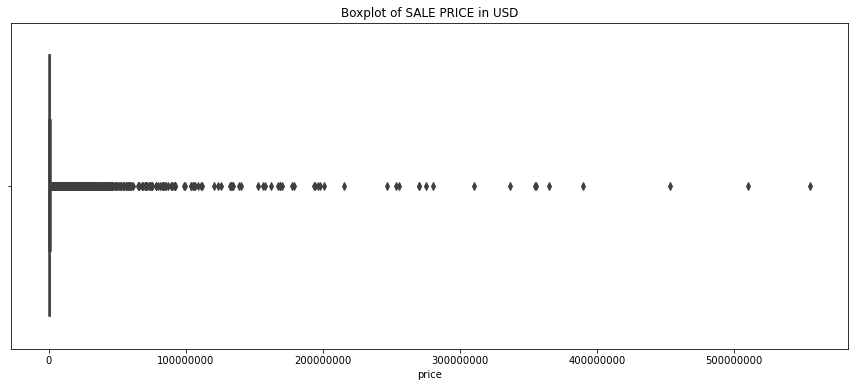

In [13]:
plt.figure(figsize=(15,6))
# Plot the data and configure the settings
sns.boxplot(x='price', data=df2)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE in USD')
plt.show()

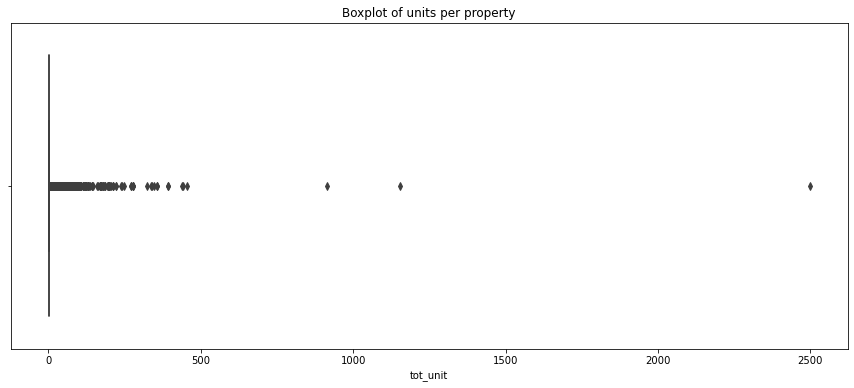

In [14]:
plt.figure(figsize=(15,6))
# Plot the data and configure the settings
sns.boxplot(x='tot_unit', data=df2)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of units per property')
plt.show()

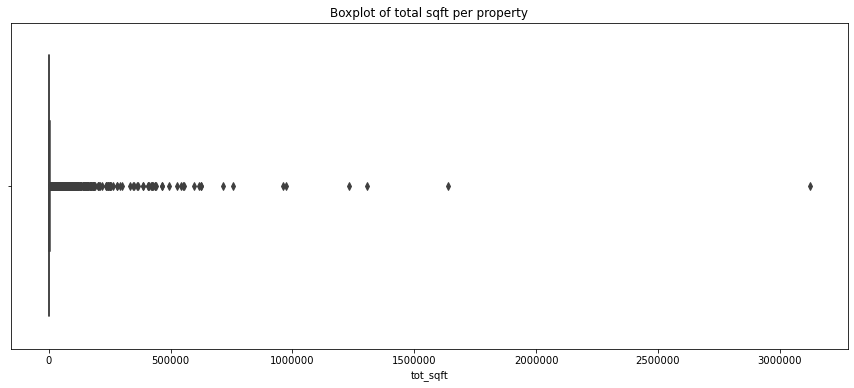

In [15]:
plt.figure(figsize=(15,6))
# Plot the data and configure the settings
sns.boxplot(x='tot_sqft', data=df2)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of total sqft per property')
plt.show()

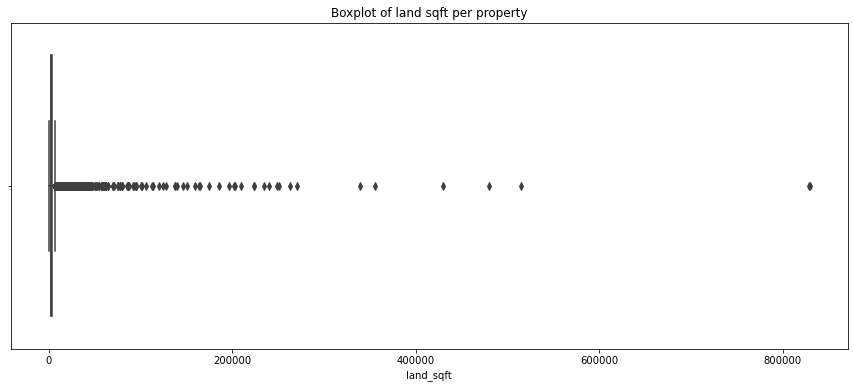

In [16]:
plt.figure(figsize=(15,6))
# Plot the data and configure the settings
sns.boxplot(x='land_sqft', data=df2)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of land sqft per property')
plt.show()

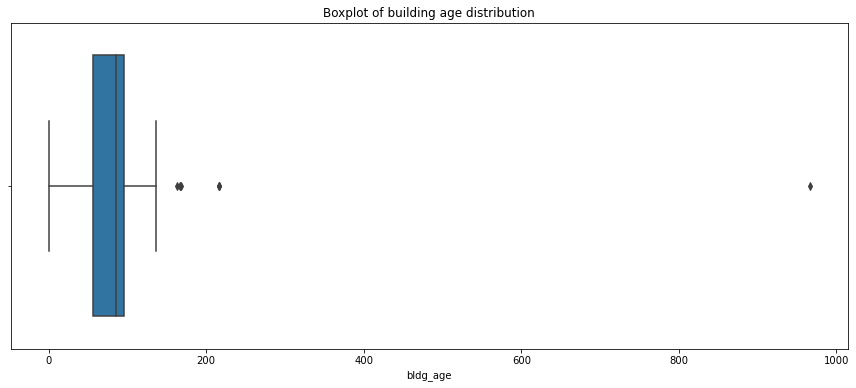

In [17]:
plt.figure(figsize=(15,6))
# Plot the data and configure the settings
sns.boxplot(x='bldg_age', data=df2)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of building age distribution')
plt.show()

In [18]:
df2 = df2[df2.price <20000000]
df2 = df2[df2.tot_unit <75]
df2 = df2[df2.tot_sqft <8000]
df2 = df2[df2.land_sqft <100000]
df2 = df2[df2.bldg_age <125]

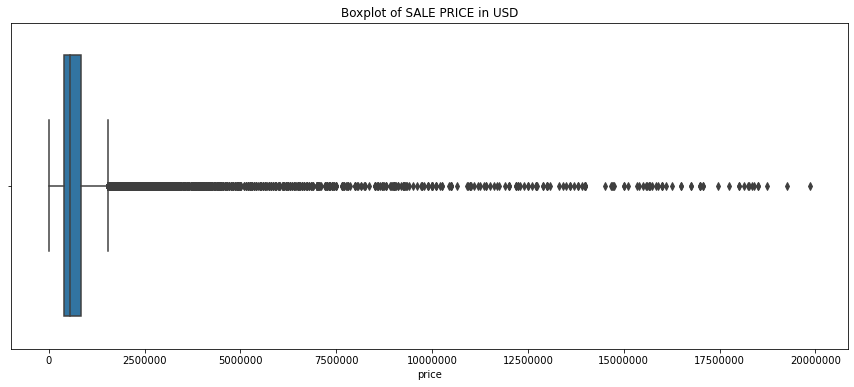

In [19]:
plt.figure(figsize=(15,6))
# Plot the data and configure the settings
sns.boxplot(x='price', data=df2)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE in USD')
plt.show()

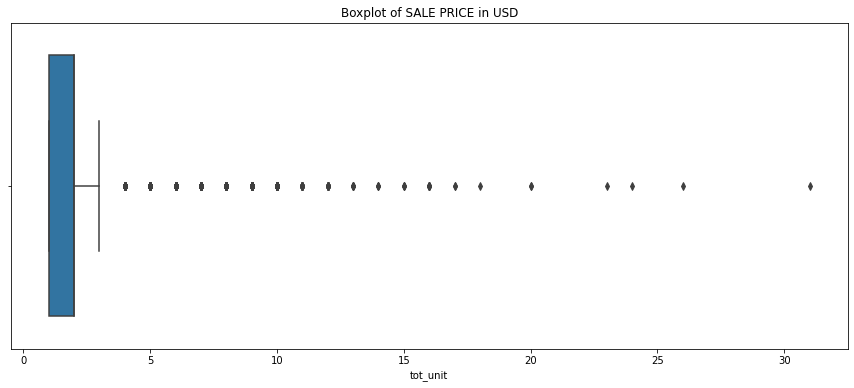

In [20]:
plt.figure(figsize=(15,6))
# Plot the data and configure the settings
sns.boxplot(x='tot_unit', data=df2)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE in USD')
plt.show()

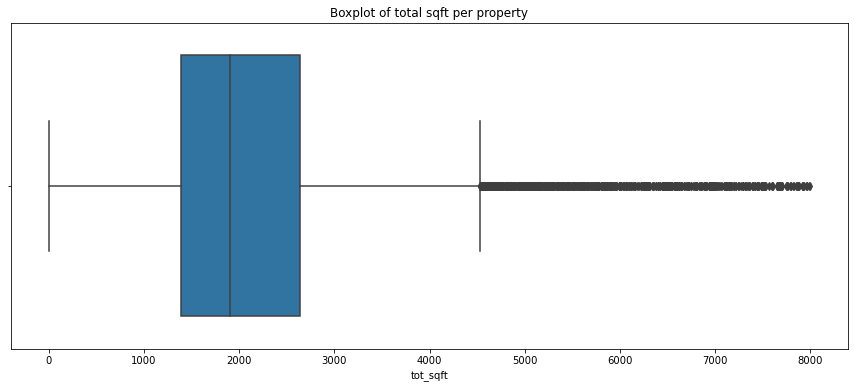

In [21]:
plt.figure(figsize=(15,6))
# Plot the data and configure the settings
sns.boxplot(x='tot_sqft', data=df2)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of total sqft per property')
plt.show()

# Data Exploration
## Visualizing data and relationship between variables 

In [22]:
Y = df2.price

Text(0.5, 1.0, 'Price vs Land sqft')

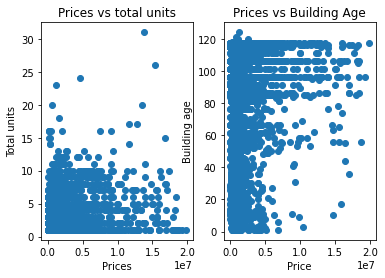

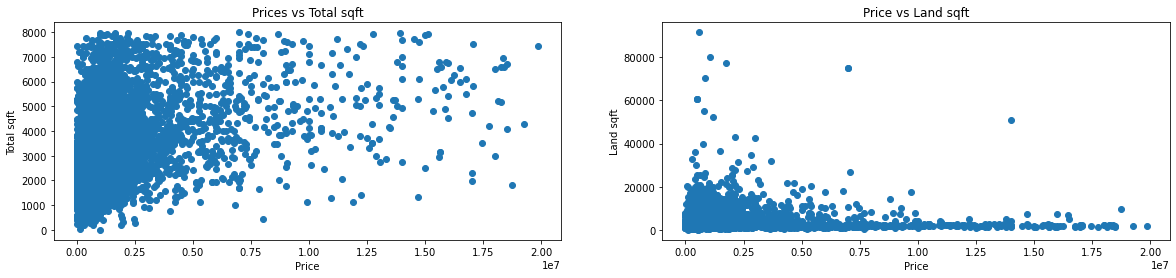

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(1, 2)
f,ax2 =plt.subplots(1, 2)
f.set_figwidth(20,20)

#ax[0].set_xlim(right=50000000)
#ax[0].set_ylim(bottom=1800, top =2015)

ax[0].scatter(Y, df2.tot_unit)
ax[0].set_xlabel("Prices")
ax[0].set_ylabel("Total units")
ax[0].set_title("Prices vs total units")


#ax[1].set_xlim(right=100000000)
#ax[0].set_ylim(bottom=1800, top =2015)

ax[1].scatter(Y, df2.bldg_age)
ax[1].set_xlabel("Price")
ax[1].set_ylabel("Building age")
ax[1].set_title("Prices vs Building Age")

#ax[0].set_xlim(0,5e8)
#ax[0].set_ylim(1800,2050)

ax2[0].scatter(Y, df2.tot_sqft)
ax2[0].set_xlabel("Price")
ax2[0].set_ylabel("Total sqft")
ax2[0].set_title("Prices vs Total sqft")

#ax[1].set_ylim(bottom = 0, top=10000)

ax2[1].scatter(Y, df2.land_sqft)
ax2[1].set_xlabel("Price")
ax2[1].set_ylabel("Land sqft")
ax2[1].set_title("Price vs Land sqft")

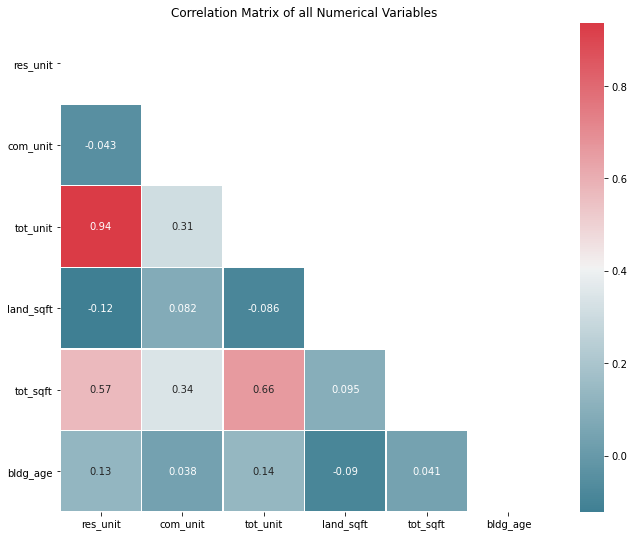

In [24]:
# Compute the correlation matrix
d= df2[["res_unit",'com_unit','tot_unit', 'land_sqft', 'tot_sqft', "bldg_age"]]
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, 
            square=True, linewidths=.5, annot=True, cmap=cmap)
plt.yticks(rotation=0)
plt.title('Correlation Matrix of all Numerical Variables')
plt.show()

## Examining correlation between different explanatory variables using VIF

### 1. Try all possible numerical variables

In [25]:
X= df2[["res_unit",'com_unit','tot_unit', 'land_sqft', 'tot_sqft', "bldg_age"]]

In [26]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.round(3)
    return(vif)

calc_vif(X)

C:\Users\mmlad\.conda\envs\Data Sci Python 36\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,res_unit,inf
1,com_unit,inf
2,tot_unit,inf
3,land_sqft,2.323
4,tot_sqft,7.672
5,bldg_age,3.732


### 2. Removing variables with highest VIF

In this case, removing "res_unit" &'com_unit' --> correlate with total units

In [27]:
X= df2[['tot_unit', 'land_sqft', 'tot_sqft', "bldg_age"]]

In [28]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.round(3)
    return(vif)

calc_vif(X)

,variables,VIF
0,tot_unit,5.399
1,land_sqft,2.322
2,tot_sqft,7.545
3,bldg_age,3.645


## Log-normalising the target

In [29]:
#Check before normalisation
#plt.figure(figsize=(10,6))
#sns.distplot(df2['price'])
#plt.title('Histogram ofprice')
#plt.show()

In [30]:
# Take the log and normalise 
# (all normalised values will be included into a separate dataframe)

In [31]:
#Check after normalisation
#plt.figure(figsize=(10,6))
#sns.distplot(df2['price'])
#plt.title('Histogram ofprice')
#plt.show()

# Define explanatory variables 

In [32]:
len(df2.zip.unique()) #174 different ZIP codes --> might be providing more homogeneity... but too many variables

171

In [33]:
#Based on VIF, remove columns from df2
df2 = df2.drop(columns=["zip", "res_unit", "com_unit",
                        "bldg_cls_s", "land_sqft","bldg_ctgy"])

In [34]:
#Trying without the one-hot encoding: 
#df2 = df2[['borough', 'tot_unit', 'land_sqft',  'tot_sqft', 'tax_cls_s','price',  'bldg_age']]

In [35]:
#Introducing sqft variable, equal to land_sqft + tot_sqft

#df2["sqft"] = df2["tot_sqft"] + df2["land_sqft"]
#df2 = df2.drop(columns =["tot_sqft","land_sqft"])
#df2 = df2[['borough', 'tot_unit', "sqft", 'tax_cls_s','price',  'bldg_age']]

# Log-normalization

In [36]:
#Log-normalisation and standardisation

#target
#df2['price'] = StandardScaler().fit_transform(np.log(df2['price'].values.reshape(-1,1)))

# Building age 
#df2['bldg_age'] = df2['bldg_age']+1
#df2['bldg_age'] = StandardScaler().fit_transform(np.log(df2['bldg_age'].values.reshape(-1,1)))

# Square feet 
#df2["tot_sqft"] = StandardScaler().fit_transform(np.log(df2["tot_sqft"].values.reshape(-1,1)))

# Number of units                                                 
#df2["tot_unit"] = df2["tot_unit"] + 1
#df2["tot_unit"] = StandardScaler().fit_transform(np.log(df2["tot_unit"].values.reshape(-1,1)))

### Removing building category (slightly worsened results)

In [37]:
#removing the building category
#very slightly worsened things
#df2 = df2.iloc[:,[0,1,2,3,4,5,6,7,8]]
#df2

# Splitting the data into train, validation, and test

In [38]:
train, validate, test = np.split(df2.sample(frac=1, random_state=50), 
                       [int(.8*len(df2)), int(.9*len(df2))])

#Separating the train, validate, and test into X and Y
y_train = train.price
y_validate = validate.price
y_test = test.price

X_train = train.drop(columns = ["price"])
X_validate = validate.drop(columns = ["price"])
X_test = test.drop(columns = ["price"])

#Creating model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [39]:
#R^2 score
print("R^2 train: {}".format(lr.score(X_train, y_train)))
print("R^2 validation: {}".format(lr.score(X_validate, y_validate)))
print("R^2 test: {}".format(lr.score(X_test, y_test)))

# Predict the labels of the validation set: y_pred
y_pred = lr.predict(X_validate)

#MAE TEST
mae = mean_absolute_error(y_validate, y_pred)
print("Root Mean Absolute Error Validation: {}".format(mae))

# Predict the labels of the test set: y_pred
y_pred = lr.predict(X_test)

#RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error Test: {}".format(rmse))

#MAE
mae = mean_absolute_error(y_test, y_pred)
print("Root Mean Absolute Error Test: {}".format(mae))

R^2 train: 0.4648286417976428
R^2 validation: 0.5261419918047248
R^2 test: 0.5188825479834402
Root Mean Absolute Error Validation: 387362.55256461113
Root Mean Squared Error Test: 881841.9464000997
Root Mean Absolute Error Test: 406535.03628895537


# Lasso regression

In [40]:
lasso = Lasso(alpha=2.0, normalize=True, max_iter=1e5) 
lasso.fit(X_train, y_train)

# R^2 scores
print('Lasso Regression R^2 scores')
print('Train:', lasso.score(X_train, y_train))
print('Validation:', lasso.score(X_validate, y_validate))
print('Test:', lasso.score(X_test, y_test))

# MAE validation
y_pred = lasso.predict(X_validate)
mae = mean_absolute_error(y_validate, y_pred)
print('Validation MAE: %.3f' % mae)

#MAE test 
y_pred = lasso.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: %.3f' % mae)

Lasso Regression R^2 scores
Train: 0.4648280888212951
Validation: 0.5262410483591164
Test: 0.518920419560412
Validation MAE: 387180.861
Test MAE: 406395.665


# Forest regression

In [41]:
RF = RandomForestRegressor(n_estimators = 100, random_state = 0) 
RF.fit(X_train, y_train)

#R2 scores train and validation sets 
print('Random Forest Regression R^2 scores')
print('Train:', RF.score(X_train, y_train))
print('Validation:', RF.score(X_validate, y_validate))
print('Test:', RF.score(X_test, y_test))

# MAE train 
y_pred = RF.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print('\n Train MAE: %.3f' % mae)

# MAE validation 
y_pred = RF.predict(X_validate)
mae = mean_absolute_error(y_validate, y_pred)
print('\n Validation MAE: %.3f' % mae)

# MAE test
y_pred = RF.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('\nMAE: %.3f' % mae)

Random Forest Regression R^2 scores
Train: 0.9010756910375436
Validation: 0.5028311357008056
Test: 0.563075642145944

 Train MAE: 171228.258

 Validation MAE: 381851.365

MAE: 380930.556


# Importing aerial data

In [42]:
from sklearn import datasets
from sklearn.model_selection import RepeatedKFold

In [43]:
image = pd.read_csv("sales_data_2015_DF-inception-conv.csv")
image = image.set_index('Sale_id')
image = image.drop(columns = ["Unnamed: 0", "bbl_id"])
image = image[(image != 0).all(1)]
image

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Sale_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.141194,0.421060,0.466694,-0.989387,0.091223,1.033919,-0.001966,-0.098034,-0.159921,0.023693,-0.424309,0.037332,-0.036936,0.114200,-0.056193,-0.450069,-0.681964,0.029796,0.089412,0.019512,0.033488,-0.163477,0.600213,-0.493792,-0.047002,-0.092415,0.427163,0.688372,-0.549481,-0.538056,0.358792,-0.103146
2,0.141194,0.421060,0.466694,-0.989387,0.091223,1.033919,-0.001966,-0.098034,-0.159921,0.023693,-0.424309,0.037332,-0.036936,0.114200,-0.056193,-0.450069,-0.681964,0.029796,0.089412,0.019512,0.033488,-0.163477,0.600213,-0.493792,-0.047002,-0.092415,0.427163,0.688372,-0.549481,-0.538056,0.358792,-0.103146
3,0.114756,0.350338,0.387500,-0.834070,0.063190,0.863413,-0.001232,-0.084781,-0.131445,0.011075,-0.356321,0.030225,-0.031919,0.095055,-0.054910,-0.377809,-0.561407,0.013183,0.076345,0.016472,0.029367,-0.137302,0.502646,-0.414158,-0.037535,-0.060672,0.358382,0.585332,-0.458778,-0.447776,0.301268,-0.086599
4,0.114901,0.351911,0.388062,-0.835415,0.068941,0.867273,-0.001948,-0.082643,-0.133502,0.016002,-0.355564,0.028320,-0.028222,0.096733,-0.051392,-0.378535,-0.565638,0.016828,0.074499,0.014374,0.028011,-0.136841,0.503530,-0.413901,-0.038112,-0.066762,0.358489,0.580582,-0.461086,-0.449793,0.301751,-0.086144
5,0.114901,0.351911,0.388062,-0.835415,0.068941,0.867273,-0.001948,-0.082643,-0.133502,0.016002,-0.355564,0.028320,-0.028222,0.096733,-0.051392,-0.378535,-0.565638,0.016828,0.074499,0.014374,0.028011,-0.136841,0.503530,-0.413901,-0.038112,-0.066762,0.358489,0.580582,-0.461086,-0.449793,0.301751,-0.086144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84764,0.035449,0.248920,0.249374,-0.677167,-0.038436,0.621761,-0.005840,-0.060394,-0.094171,-0.028299,-0.273685,-0.019758,0.020690,0.072187,-0.089715,-0.285341,-0.388770,-0.094317,0.055689,0.014703,0.019893,-0.101304,0.382556,-0.321290,-0.030361,0.090807,0.282376,0.503989,-0.333753,-0.315923,0.223577,-0.056866
84765,0.013916,0.216111,0.205949,-0.607184,-0.047402,0.535867,-0.008138,-0.054280,-0.085372,-0.023892,-0.239589,-0.036161,0.042584,0.065589,-0.085390,-0.248685,-0.341635,-0.108524,0.049867,0.014541,0.016363,-0.087558,0.336716,-0.284883,-0.027575,0.111349,0.251931,0.450911,-0.290490,-0.273913,0.191676,-0.046153
84766,-0.028915,0.177418,0.146153,-0.562748,-0.098292,0.442333,-0.012744,-0.049112,-0.073618,-0.040359,-0.209176,-0.067429,0.078175,0.054728,-0.105281,-0.213723,-0.275327,-0.168279,0.044297,0.013015,0.015089,-0.075432,0.294367,-0.253488,-0.022022,0.192524,0.226674,0.429164,-0.244548,-0.223428,0.160768,-0.032834


In [44]:
df2 = df2.join(image)
df2

,tot_unit,tot_sqft,price,bldg_age,borough_Bronx,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,tax_cls_s_a,tax_cls_s_b,tax_cls_s_d,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Sale_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,2,2452,400000,106,1,0,0,0,0,1,0,0,0.114901,0.351911,0.388062,-0.835415,0.068941,0.867273,-0.001948,-0.082643,-0.133502,0.016002,-0.355564,0.028320,-0.028222,0.096733,-0.051392,-0.378535,-0.565638,0.016828,0.074499,0.014374,0.028011,-0.136841,0.503530,-0.413901,-0.038112,-0.066762,0.358489,0.580582,-0.461086,-0.449793,0.301751,-0.086144
8,2,2400,430000,23,1,0,0,0,0,1,0,0,0.105824,0.327731,0.363355,-0.803895,0.027193,0.820350,0.000975,-0.076084,-0.116712,-0.015371,-0.343971,0.033535,-0.043393,0.089633,-0.072723,-0.363858,-0.511580,-0.012120,0.069690,0.015504,0.026007,-0.130096,0.479302,-0.395842,-0.036620,-0.021969,0.343046,0.584889,-0.432926,-0.418085,0.292563,-0.083255
9,2,2400,10000,23,1,0,0,0,0,1,0,0,0.101585,0.315796,0.350267,-0.771425,0.028748,0.786739,0.000740,-0.076422,-0.112781,-0.012537,-0.329783,0.031486,-0.039941,0.090619,-0.068338,-0.350550,-0.493581,-0.010490,0.069108,0.015038,0.027767,-0.126342,0.460451,-0.379009,-0.036386,-0.022898,0.329450,0.559684,-0.415860,-0.403403,0.280476,-0.079723
10,2,2394,505000,21,1,0,0,0,0,1,0,0,0.099142,0.281637,0.324657,-0.735360,-0.052358,0.733772,0.009683,-0.071737,-0.079713,-0.083412,-0.322006,0.058767,-0.093172,0.086124,-0.114585,-0.340659,-0.397580,-0.056874,0.064852,0.019137,0.023473,-0.117101,0.430004,-0.356712,-0.033778,0.052749,0.310742,0.591258,-0.378233,-0.359148,0.278349,-0.079215
11,3,3240,490000,85,1,0,0,0,0,1,0,0,0.109671,0.344990,0.379070,-0.827211,0.057249,0.851783,-0.001726,-0.079784,-0.129961,0.009346,-0.352575,0.026218,-0.027492,0.093221,-0.056978,-0.372965,-0.553889,0.006184,0.073003,0.016288,0.026285,-0.134310,0.496972,-0.410028,-0.038340,-0.051503,0.355177,0.582540,-0.452473,-0.440415,0.297595,-0.084592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84759,2,1200,465000,18,0,0,0,0,1,1,0,0,0.056092,0.276280,0.287255,-0.721417,-0.015100,0.686295,-0.004373,-0.070306,-0.103287,-0.020784,-0.296686,-0.005502,0.004964,0.079593,-0.083003,-0.311509,-0.432942,-0.068636,0.063353,0.015422,0.024958,-0.112408,0.415541,-0.346203,-0.032018,0.054776,0.303259,0.529521,-0.367362,-0.351836,0.245152,-0.064655
84760,2,1550,515000,19,0,0,0,0,1,1,0,0,0.037952,0.233438,0.237064,-0.630220,-0.032066,0.584986,-0.004762,-0.056277,-0.087212,-0.026766,-0.255545,-0.012977,0.012421,0.066462,-0.082075,-0.267507,-0.362271,-0.080948,0.051649,0.011749,0.019978,-0.095722,0.357549,-0.299350,-0.027244,0.075906,0.262400,0.468075,-0.313283,-0.296365,0.210706,-0.054186
84762,2,1600,165000,19,0,0,0,0,1,1,0,0,0.039367,0.249412,0.252682,-0.670072,-0.031891,0.620588,-0.005609,-0.062432,-0.093806,-0.026084,-0.271647,-0.015542,0.016076,0.074772,-0.085970,-0.285330,-0.389256,-0.085817,0.056677,0.012919,0.023643,-0.103196,0.380773,-0.317341,-0.031028,0.079889,0.279554,0.497041,-0.333255,-0.317143,0.223478,-0.057336


In [45]:
#checking for NaN or infinite values 
print(np.any(np.isnan(df2)))
print(np.all(np.isfinite(df2)))

True
False


In [46]:
df2.dropna(inplace = True)

In [47]:
df2

,tot_unit,tot_sqft,price,bldg_age,borough_Bronx,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,tax_cls_s_a,tax_cls_s_b,tax_cls_s_d,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Sale_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,2,2452,400000,106,1,0,0,0,0,1,0,0,0.114901,0.351911,0.388062,-0.835415,0.068941,0.867273,-0.001948,-0.082643,-0.133502,0.016002,-0.355564,0.028320,-0.028222,0.096733,-0.051392,-0.378535,-0.565638,0.016828,0.074499,0.014374,0.028011,-0.136841,0.503530,-0.413901,-0.038112,-0.066762,0.358489,0.580582,-0.461086,-0.449793,0.301751,-0.086144
8,2,2400,430000,23,1,0,0,0,0,1,0,0,0.105824,0.327731,0.363355,-0.803895,0.027193,0.820350,0.000975,-0.076084,-0.116712,-0.015371,-0.343971,0.033535,-0.043393,0.089633,-0.072723,-0.363858,-0.511580,-0.012120,0.069690,0.015504,0.026007,-0.130096,0.479302,-0.395842,-0.036620,-0.021969,0.343046,0.584889,-0.432926,-0.418085,0.292563,-0.083255
9,2,2400,10000,23,1,0,0,0,0,1,0,0,0.101585,0.315796,0.350267,-0.771425,0.028748,0.786739,0.000740,-0.076422,-0.112781,-0.012537,-0.329783,0.031486,-0.039941,0.090619,-0.068338,-0.350550,-0.493581,-0.010490,0.069108,0.015038,0.027767,-0.126342,0.460451,-0.379009,-0.036386,-0.022898,0.329450,0.559684,-0.415860,-0.403403,0.280476,-0.079723
10,2,2394,505000,21,1,0,0,0,0,1,0,0,0.099142,0.281637,0.324657,-0.735360,-0.052358,0.733772,0.009683,-0.071737,-0.079713,-0.083412,-0.322006,0.058767,-0.093172,0.086124,-0.114585,-0.340659,-0.397580,-0.056874,0.064852,0.019137,0.023473,-0.117101,0.430004,-0.356712,-0.033778,0.052749,0.310742,0.591258,-0.378233,-0.359148,0.278349,-0.079215
11,3,3240,490000,85,1,0,0,0,0,1,0,0,0.109671,0.344990,0.379070,-0.827211,0.057249,0.851783,-0.001726,-0.079784,-0.129961,0.009346,-0.352575,0.026218,-0.027492,0.093221,-0.056978,-0.372965,-0.553889,0.006184,0.073003,0.016288,0.026285,-0.134310,0.496972,-0.410028,-0.038340,-0.051503,0.355177,0.582540,-0.452473,-0.440415,0.297595,-0.084592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84759,2,1200,465000,18,0,0,0,0,1,1,0,0,0.056092,0.276280,0.287255,-0.721417,-0.015100,0.686295,-0.004373,-0.070306,-0.103287,-0.020784,-0.296686,-0.005502,0.004964,0.079593,-0.083003,-0.311509,-0.432942,-0.068636,0.063353,0.015422,0.024958,-0.112408,0.415541,-0.346203,-0.032018,0.054776,0.303259,0.529521,-0.367362,-0.351836,0.245152,-0.064655
84760,2,1550,515000,19,0,0,0,0,1,1,0,0,0.037952,0.233438,0.237064,-0.630220,-0.032066,0.584986,-0.004762,-0.056277,-0.087212,-0.026766,-0.255545,-0.012977,0.012421,0.066462,-0.082075,-0.267507,-0.362271,-0.080948,0.051649,0.011749,0.019978,-0.095722,0.357549,-0.299350,-0.027244,0.075906,0.262400,0.468075,-0.313283,-0.296365,0.210706,-0.054186
84762,2,1600,165000,19,0,0,0,0,1,1,0,0,0.039367,0.249412,0.252682,-0.670072,-0.031891,0.620588,-0.005609,-0.062432,-0.093806,-0.026084,-0.271647,-0.015542,0.016076,0.074772,-0.085970,-0.285330,-0.389256,-0.085817,0.056677,0.012919,0.023643,-0.103196,0.380773,-0.317341,-0.031028,0.079889,0.279554,0.497041,-0.333255,-0.317143,0.223478,-0.057336


## Splitting data

In [48]:
train, validate, test = np.split(df2.sample(frac=1, random_state=65), 
                       [int(.8*len(df2)), int(.9*len(df2))])

#Separating the train, validate, and test into X and Y
y_train = train.price
y_validate = validate.price
y_test = test.price

X_train = train.drop(columns = ["price"])
X_validate = validate.drop(columns = ["price"])
X_test = test.drop(columns = ["price"])

## Linear Regression 

In [49]:
#Creating model
lr = LinearRegression()
lr.fit(X_train, y_train)

#R^2 score
print("R^2 train: {}".format(lr.score(X_train, y_train)))
print("R^2 validation: {}".format(lr.score(X_validate, y_validate)))
print("R^2 test: {}".format(lr.score(X_test, y_test)))

# Predict the labels of the validation set: y_pred
y_pred = lr.predict(X_validate)

#RMSE 
rmse = np.sqrt(mean_squared_error(y_validate, y_pred))
print("Root Mean Squared Error Validation: {}".format(rmse))

#MAE TEST
mae = mean_absolute_error(y_validate, y_pred)
print("Root Mean Absolute Error Validation: {}".format(mae))

# Predict the labels of the test set: y_pred
y_pred = lr.predict(X_test)

#RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error Test: {}".format(rmse))

#MAE
mae = mean_absolute_error(y_test, y_pred)
print("Root Mean Absolute Error Test: {}".format(mae))

R^2 train: 0.4707431670121345
R^2 validation: 0.5273457362614888
R^2 test: 0.5211378368578975
Root Mean Squared Error Validation: 758637.7920551163
Root Mean Absolute Error Validation: 391072.90455340105
Root Mean Squared Error Test: 834244.2333108608
Root Mean Absolute Error Test: 391984.90255986474


## Lasso Regression

In [50]:
lasso = Lasso(alpha=2.0, normalize=True, max_iter=1e5) 
lasso.fit(X_train, y_train)

# R^2 scores
print('Lasso Regression R^2 scores')
print('Train:', lasso.score(X_train, y_train))
print('Validation:', lasso.score(X_validate, y_validate))
print('Test:', lasso.score(X_test, y_test))

# MAE validation
y_pred = lasso.predict(X_validate)
mae = mean_absolute_error(y_validate, y_pred)
print('Validation MAE: %.3f' % mae)

#MAE test 
y_pred = lasso.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: %.3f' % mae)

Lasso Regression R^2 scores
Train: 0.470207884034468
Validation: 0.52723648803426
Test: 0.5218094335490433
Validation MAE: 388273.083
Test MAE: 390944.909


## Forrest regression

In [51]:
RF = RandomForestRegressor(n_estimators = 100, random_state = 0) 
RF.fit(X_train, y_train)

#R2 scores train and validation sets 
print('Random Forest Regression R^2 scores')
print('Train:', RF.score(X_train, y_train))
print('Validation:', RF.score(X_validate, y_validate))
print('Test:', RF.score(X_test, y_test))

# MAE train 
y_pred = RF.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print('\n Train MAE: %.3f' % mae)

# MAE validation 
y_pred = RF.predict(X_validate)
mae = mean_absolute_error(y_validate, y_pred)
print('\n Validation MAE: %.3f' % mae)

# MAE test
y_pred = RF.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('\nMAE: %.3f' % mae)

Random Forest Regression R^2 scores
Train: 0.9407887195403207
Validation: 0.6605529536069288
Test: 0.5405970203033417

 Train MAE: 129132.309

 Validation MAE: 315512.311

MAE: 335229.999


# Results summary

In [52]:
summary = pd.read_excel("summary.xlsx")
summary.columns
summary.info()
summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Model   6 non-null      object 
 1   R^2     6 non-null      float64
 2   MAE     6 non-null      int64  
 3   Images  6 non-null      object 
dtypes: float64(1), int64(1), object(2)
memory usage: 320.0+ bytes


,Model,R^2,MAE,Images
0,Linear regression,0.520,406535,no
1,Lasso regression,0.520,406395,no
2,Random forest regressor,0.563,380930,no
3,Linear regression,0.520,391984,yes
4,Lasso regression,0.520,390944,yes
5,Random forest regressor,0.540,335229,yes


<AxesSubplot:xlabel='Model', ylabel='R^2'>

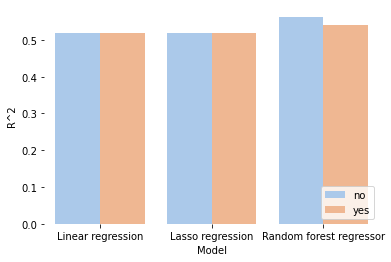

In [53]:
#sns.set_color_codes("pastel")
#

ax = sns.barplot(x="Model", y="R^2", data=summary,
                 palette="pastel", hue ="Images")
sns.despine(left=True, bottom=True)
plt.legend(loc='lower right')
ax

In [54]:
print(summary.columns)

Index(['Model', 'R^2', 'MAE ', 'Images'], dtype='object')


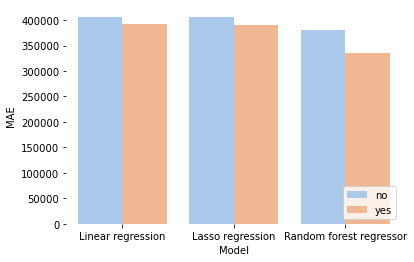

In [55]:
#palette="pastel"
sns.barplot(x="Model", y="MAE ", data=summary,
            hue ="Images",palette="pastel")
sns.despine(left=True, bottom=True)
plt.legend(loc='lower right')
